In [1]:
library(readxl)
library(reshape2)
library(ggplot2)
library(tibble)
library(tidyr)
library(dplyr)
library(ggtext)
library(latex2exp)
library(stringr)
library(cowplot)
library(patchwork)


Warning message:
"Paket 'ggplot2' wurde unter R Version 4.2.3 erstellt"
Warning message:
"Paket 'tibble' wurde unter R Version 4.2.3 erstellt"

Attache Paket: 'tidyr'


Das folgende Objekt ist maskiert 'package:reshape2':

    smiths


Warning message:
"Paket 'dplyr' wurde unter R Version 4.2.3 erstellt"

Attache Paket: 'dplyr'


Die folgenden Objekte sind maskiert von 'package:stats':

    filter, lag


Die folgenden Objekte sind maskiert von 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"Paket 'latex2exp' wurde unter R Version 4.2.3 erstellt"

Attache Paket: 'patchwork'


Das folgende Objekt ist maskiert 'package:cowplot':

    align_plots




## Figure 4
### Influence of initial marsh elevation, water level, and tidal regime on marsh vulnerability. 
The figure shows the distribution to vulnerability classes across four marsh zones —- mud-
flat, pioneer zone, low marsh, and high marsh —- under various policy actions and categorical
uncertainties. The highlighted bars represents accretion models for the pioneer zone in focus area
S15, based on RCP8.5 sea level and tidal regime projections.

### Load plotting data
Plotting data: 6480 models for each focus area. The estimated critical year outcome, associated with each model representing a future marsh state, is used as an indicator for class assignment. 

Definition of custom color for marsh zone mapping

In [3]:

color_table <- tibble(
  ordnung = c("Mudflat", "PioneerZone", "LowMarsh", "HighMarsh"),
  color   = c("#b7a392", "#91afa1", "#abc17a", "#7fa25a")
)

#### Load & reshape data for the East - Frisian islands (focus area S15)
Reshaping the data from wide to long format and prepares factor variables (RCP_f, Type_f, Zone_f) with specific level orders to organize the dataset for structured facet plotting by scenario (RCP), type, and zone.

In [4]:
east <- read_excel("../data/figure_4_data.xlsx", sheet = "TIME_WINDOWS_east_frisian")

east <- east %>% mutate(transects = "S15")
east_cut=east[, 2:7]
east_long=melt(east_cut, id=c("Type", "Zone", "transects"))

east_long <-east_long %>%
  mutate(
    RCP     = as.character(variable),
    Zone    = factor(Zone,    levels = color_table$ordnung),
    RCP_f   = factor(RCP,     levels = c("RCP 8.5", "RCP 4.5", "RCP 2.6")),
    Type_f  = factor(Type,    levels = c("Critical", "Susceptible", "Undecidable", "Favorable")),
    Zone_f  = factor(Zone,    levels = color_table$ordnung)
  )

#### Load & reshape data for the Weser-Elbe Delta (focus area S33)


In [5]:
weser <- read_excel("../data/figure_4_data.xlsx", sheet = "TIME_WINDOWS_weser_elbe")
weser <- weser %>%
  mutate(transects = "S33")

weser_cut  <- weser[, 2:7]
weser_long <- melt(weser_cut, id.vars = c("Type", "Zone", "transects"))
weser_long <- weser_long %>%
  mutate(
    RCP     = as.character(variable),
    Zone    = factor(Zone,    levels = color_table$ordnung),
    RCP_f   = factor(RCP,     levels = c("RCP 8.5", "RCP 4.5", "RCP 2.6")),
    Type_f  = factor(Type,    levels = c("Critical", "Susceptible", "Undecidable", "Favorable")),
    Zone_f  = factor(Zone,    levels = color_table$ordnung)
  )

### Combine datasets for both focus areas and plot 
Plot grouped bar charts of modeled state percentages by type and zone, faceted by transect and RCP scenario, with class labels and highlighted pioneer zone values under RCP 8.5 for transect S15.

In [6]:
data_long <- bind_rows(east_long, weser_long)
data_long$transects_f <- factor(data_long$transects, levels = c("S15", "S33"))


# build the ggplot
gg <- ggplot(data_long, aes(x = Type_f, y = value, fill = Zone_f)) +
  geom_col(width = 0.9, position = position_dodge2(preserve = "single")) +
  scale_y_continuous(limits = c(0, 110), breaks = seq(0, 100, 25)) +
  geom_vline(xintercept = c(1.5, 2.5, 3.5), alpha = 0.6) +
  geom_hline(yintercept = max(data_long$value) + 5, alpha = 0.6) +
  geom_text(data = data_long %>%
              distinct(Type_f) %>%
              mutate(
                y     = max(data_long$value),
                label = paste0(
                  c("Class I:\n", "Class II:\n", "Class III:\n", "Class IV:\n"),
                  Type_f
                ),
                x     = as.numeric(Type_f)
              ),
            aes(x = x, y = y, label = label),
            inherit.aes = FALSE,
            size = 4, hjust = 0.5, vjust = -0.6
  ) +
  geom_text(aes(label = round(value, 1), group = Zone_f),
            position = position_dodge2(width = 0.9),
            vjust = -0.5, size = 4
  ) +
  facet_grid(transects ~ RCP_f, scales = "free", space = "free") +
  # highlight PioneerZone, RCP8.5, S15
  geom_col(data = data_long %>%
             filter(Zone_f == "PioneerZone", RCP_f == "RCP 8.5", transects == "S15"),
           aes(x = as.numeric(Type_f) - 0.11, y = value),
           fill = NA, color = "black", linewidth = 1, width = 0.2
  ) +
  scale_fill_manual(breaks = color_table$ordnung,
                    values = color_table$color,
                    name   = "") +
  labs(x = NULL, y = "Percentage of modeled states") +
  theme_bw() +
  theme(
    panel.grid       = element_blank(),
    axis.ticks.length = unit(-0.05, "in"),
    legend.position  = "bottom",
    strip.text       = element_text(size = 14, hjust = 0.5),
    strip.background = element_rect(fill = NA, colour = "black"),
    axis.text.x      = element_blank(),
    axis.ticks.x     = element_blank(),
    axis.text.y      = element_text(size = 14),
    axis.title.y     = element_text(size = 15),
    legend.text      = element_text(size = 15)
  ) +
  guides(fill = guide_legend(ncol = 5))


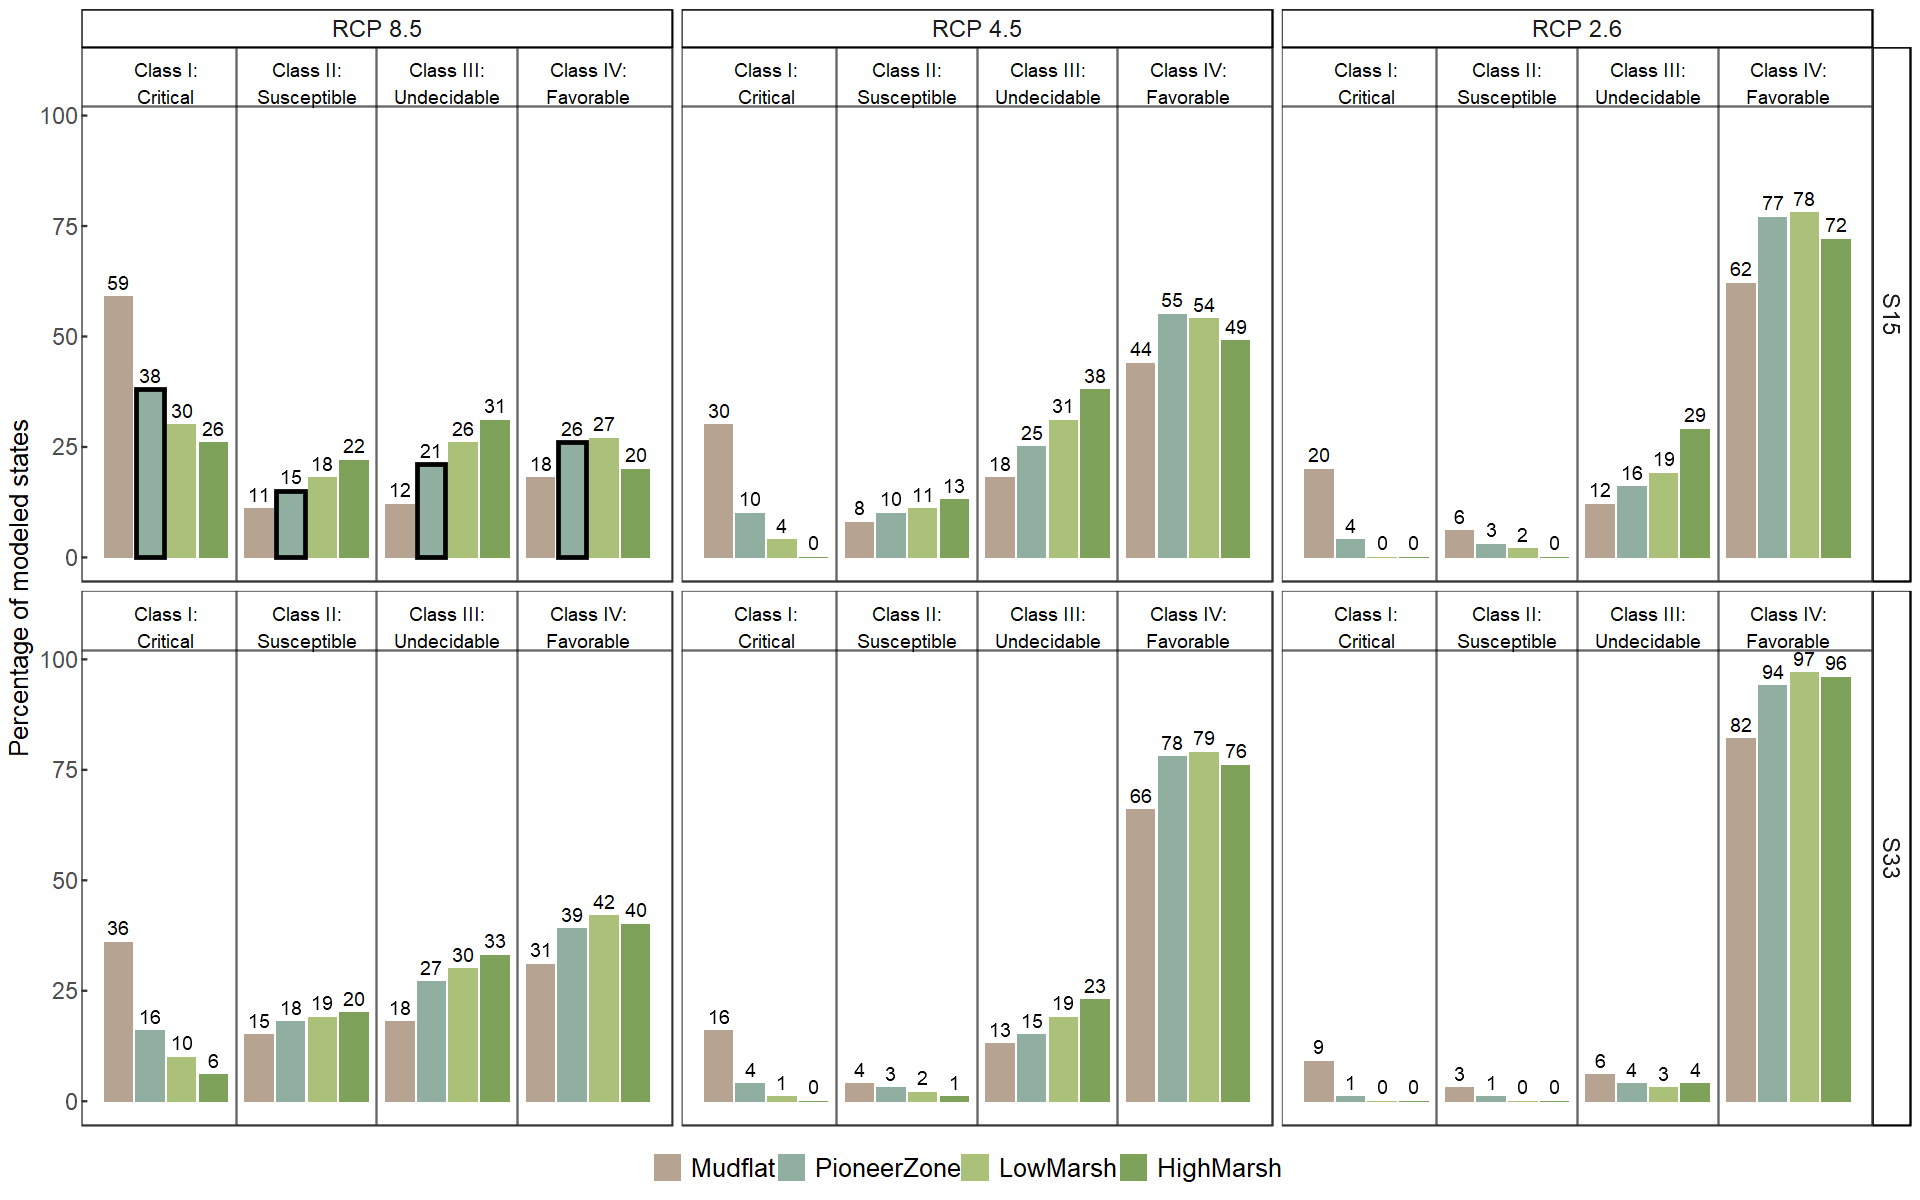

In [7]:
options(repr.plot.width = 16, repr.plot.height = 10)
print(gg)